# Airbnb U.S Market Analysis

In [18]:
#basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context()
#scickit-toolkits
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_predict,cross_val_score,  cross_validate, train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
%matplotlib inline

## Data

In [2]:
df = pd.read_csv('/Users/weiyiwang/code/TheWangAndOnly/AirBnB/Dataset/AB_US_2020.csv')

/Users/weiyiwang/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


The dataset provided has columns describing features such as host id, hostname, listing id, listing name, latitude and longitude of listing, the neighbourhood, price, room type, minimum number of nights, number of reviews, last review date, reviews per month, availability, host listings and city.

### EDA 

In [4]:
df.isna().value_counts().count()

12

In [5]:
#firstly need to check if the data looks clean
df.isna().sum()/len(df) * 100
#it looks like there are several elements missing in last_review, neighbourhood_group & reviews_per_month

id                                 0.000000
name                               0.012388
host_id                            0.000000
host_name                          0.014600
neighbourhood_group               51.252046
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       21.502455
reviews_per_month                 21.502455
calculated_host_listings_count     0.000000
availability_365                   0.000000
city                               0.000000
dtype: float64

In [6]:
df.dtypes.value_counts()

int64      7
object     7
float64    3
dtype: int64

In [7]:
df.neighbourhood_group.isna().value_counts()

True     115845
False    110185
Name: neighbourhood_group, dtype: int64

### Dropping Columns

In the case of analyzing the price of AirBnB habitations, the id, host_id, neighbourhood_group (50% missing), 

In [8]:
#Dropping irrelevant columns in the case of this analysis 

df.drop(columns=['id','host_id', 'host_name', 'neighbourhood_group', 'neighbourhood'], inplace=True)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225733 entries, 0 to 226029
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   name                            225705 non-null  object 
 1   latitude                        225733 non-null  float64
 2   longitude                       225733 non-null  float64
 3   room_type                       225733 non-null  object 
 4   price                           225733 non-null  int64  
 5   minimum_nights                  225733 non-null  int64  
 6   number_of_reviews               225733 non-null  int64  
 7   last_review                     177428 non-null  object 
 8   reviews_per_month               177428 non-null  float64
 9   calculated_host_listings_count  225733 non-null  int64  
 10  availability_365                225733 non-null  int64  
 11  city                            225733 non-null  object 
dtypes: float64(3), i

### Target

<AxesSubplot:xlabel='price', ylabel='city'>

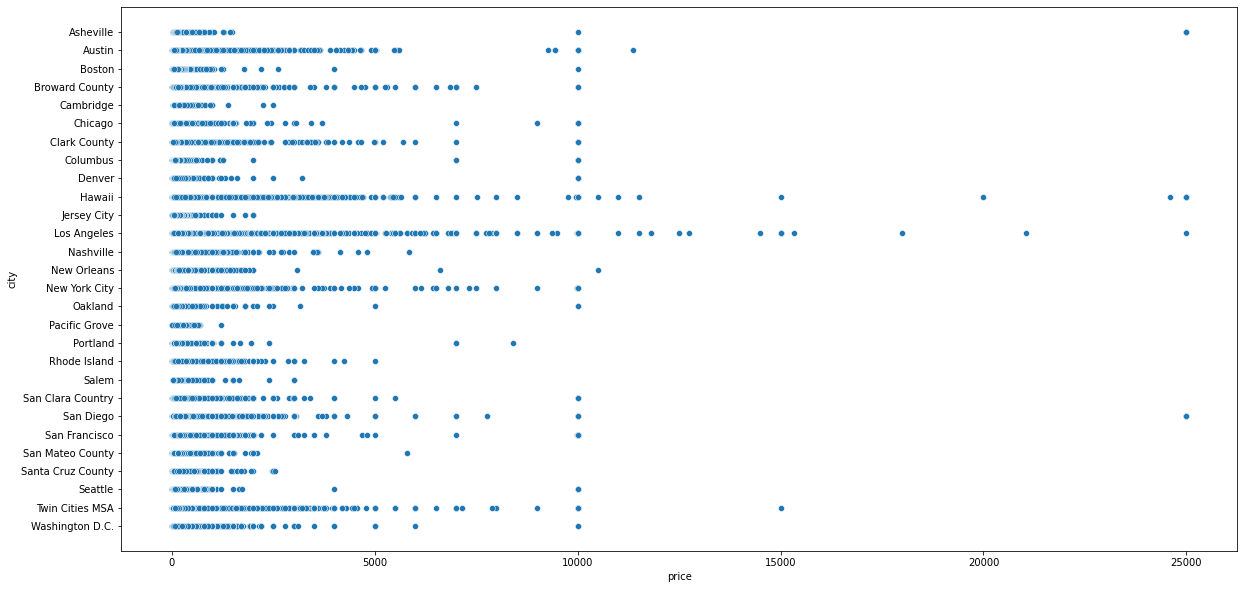

In [11]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=df['price'], y=df['city'])

<AxesSubplot:xlabel='price'>

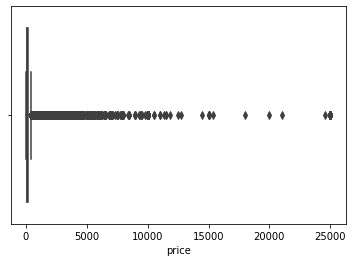

In [12]:
sns.boxplot(data=df, x='price')

It looks like there some outliers in the target, but let's try a model nonetheless

In [16]:
X = df.drop(columns=['price'])
y = df['price']

In [17]:
num_encoder = Pipeline([('simple_imputer', SimpleImputer(strategy = 'constant', fill_value=1)),
                        ('rob_scaler', RobustScaler())])

cat_encoder = Pipeline([('simple_imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
                        ('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


preproc = ColumnTransformer([('num_encoder', num_encoder, make_column_selector(dtype_include=['int64','float64'])),
                             ('cat_encoder', cat_encoder , make_column_selector(dtype_include=['object']))
                              ])

baseline_pipe = Pipeline([('preprocessing', preproc),
                          ('model', LinearRegression())
                        ])
baseline_pipe

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_encoder',
                                                  Pipeline(memory=None,
                                                           steps=[('simple_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                              

In [ ]:
base = cross_val_score(baseline_pipe, X,y)

In [ ]:
print(base)